<a href="https://colab.research.google.com/github/ac9989/Class101_ML/blob/main/Ch6_%EB%A9%94%ED%83%80%EB%9F%AC%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#지금까지 머신러닝 문제
###머신러닝 문재 해결 흐름도
1. 훈련용 데이터(입력, 레이블) 준비
2. 모델 설정(딥러닝 구조 설정, 뉴런 네트워크 등등)
3. 훈련용 데이터를 통한 모델 최적화
4. 운영 입력데이터를 모델에 적용

##이 방식에서 개선시킬 점은 무엇일까?
###매번 새로운 문제를 만날 때 마다 **새로운 모델 생성 및 학습**

예시) 
- 사람: 자전거 지식 : θ, 오토바이 지식 : θ'

즉 지식 전이간 별도의 정보 프로세스가 크게 필요하지않음

- 인공지능 : 자전거 지식 : θ, 오토바이 지식 δ

즉 지식 전이간 추가적인 정보 프로세스가 필요함

===> 인간의 유연함, 학습을 학습함 = 메타러닝


#메타러닝 : Model Agnostic Meta-learning
###용어 정리
T(task) : 새롭게 마주하는 문제(자전거타기, 오토바이타기, 승마)

K(shot) : T에서 추출한 데이터 수, 잘 학습될수록 K의 값은 작아짐 (자전거, 오토바이, 말을 탄 횟수)

θ : 지식(NN파라미터)

$f(θ)$ : 지식을 가지고 얻은 문제의 결과

###알고리즘
1: randomly initialize θ

2: while not done do

3: ..Sample batch of tasks $ \mathcal{T}_i \sim p(\mathcal{T}) $

4: ..for all $\mathcal{T}_i$ do

5: ....Evaluate $∇_\theta \mathcal{L} (f_θ) $ with respect to $K$ example

6: ....Compute adapted parameters with gradient descent: $ θ` _{i} = θ - α∇_{θ} \mathcal{L} _{\mathcal{T}_{i}}(f_θ)$

7: ..end for

8: ..Update $θ ← θ - β∇_{θ} ∑_{\mathcal{T}_i \sim p(\mathcal{T})}\mathcal{L}_{\mathcal{T}_i} (f_{θ`_{i}})$

9: end while

###알고리즘 해석
1. Task 추출(3번줄)
2. Task로 부터 K개의 샘플 데이터 추출(5번줄)
3. 기존 지식과 차이를 이용해 새로운 지식 확보(6번줄) => inner loop(Task training)
4. 추출한 Task 모두에 대해 1~3번 과정을 반복하고 얻은 지식으로 기존 지식을 업데이트 : 메타러닝 (8번줄) => outer loop(Meta training)

#MAML 사인파 생성 예시

- 추가 라이브러리 higher 설치(메타러닝을 위해 페이스북에서 만든 라이브러리) -> inner loop

In [4]:
!pip install higher

- 라이브러리 호출

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import higher
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

- 임의의 사인파 생성함수 $f(x)=A sin(x+b)$
  - paper에 나와있는 방식
  - $x$의 범위 : $-5 ≤ x ≤ 5 $ 
  - $A$의 범위 : $0.1 ≤ A ≤ 5 $ 
  - $b$의 범위 : $0 ≤ b ≤ π $ 

In [7]:
def gen_sinusoid(x):
  a = np.random.uniform(0.1,5)
  b = np.random.uniform(0,np.pi)
  return a*np.sin(x+b)

#임의의 사인파 생성
 - Regression 문제 해결

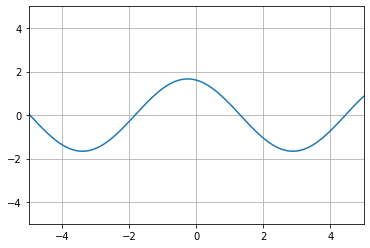

In [8]:
x = np.linspace(-5,5,100)
f_x = gen_sinusoid(x)
plt.plot(x,f_x)
plt.axis([-5,5,-5,5])
plt.grid()

In [9]:
#간단한 neural network - 위 sine 그래프 맞추기
#입력(1) > 히든1(45) > 히든2(45) > 출력(1)
class simple_sinusoid(nn.Module):
  def __init__(self):
    super(simple_sinusoid,self).__init__()
    self.lin1 = nn.Linear(1,45)
    self.lin2 = nn.Linear(45,45)
    self.lin3 = nn.Linear(45,1)
  def forward(self,x):
    x = F.elu(self.lin1(x))
    x = F.elu(self.lin2(x))
    x = self.lin3(x)
    return x

In [10]:
class dataset(torch.utils.data.Dataset):
  def __init__(self,x,y):
    self.x = x
    self.y = y
  def __getitem__(self,idx):
    return torch.Tensor(self.x).view(-1,1).to(device), torch.Tensor(self.y).view(-1,1).to(device)
  def __len__(self):
    return len(self.x)

# x: 입력, f_x(y): 레이블
data = np.concatenate((x.reshape(-1,1),f_x.reshape(-1,1)),axis=1)
np.random.shuffle(data)
train_data = data[:int(0.8*len(data))]
val_data = data[int(0.8*len(data)):]

train_data = dataset(train_data[:,0],train_data[:,1])
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True,drop_last=False)
val_data = dataset(train_data[:,0],train_data[:,1])
val_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True,drop_last=False)

In [11]:
model = simple_sinusoid().to(device)
opt = optim.Adam(model.parameters(),lr=0.01)

for epoch in range(100):
  model.train()
  t_l = 0
  for x_t,f_t in train_loader:
    opt.zero_grad()
    f_pred = model(x_t)
    loss = torch.mean((f_pred-f_t)**2)
    loss.backward()
    opt.step()
    t_l += loss.item()
  t_l /= len(train_loader)

  model.eval()
  v_l = 0
  for x_v,f_v in val_loader:
    f_pred = model(x_v)
    loss = torch.mean((f_pred-f_v)**2)
    v_l += loss.item()
  v_l /= len(val_loader)

  if epoch % 10 == 0:
    print('Epoch: {:d}, Train_Loss: {:.3f}, Vaildation Loss: {:.3f}'.format(epoch,t_l,v_l))

Epoch: 0, Train_Loss: 1.115, Vaildation Loss: 0.849
Epoch: 10, Train_Loss: 0.142, Vaildation Loss: 0.130
Epoch: 20, Train_Loss: 0.012, Vaildation Loss: 0.010
Epoch: 30, Train_Loss: 0.002, Vaildation Loss: 0.002
Epoch: 40, Train_Loss: 0.004, Vaildation Loss: 0.001
Epoch: 50, Train_Loss: 0.001, Vaildation Loss: 0.001
Epoch: 60, Train_Loss: 0.000, Vaildation Loss: 0.000
Epoch: 70, Train_Loss: 0.002, Vaildation Loss: 0.006
Epoch: 80, Train_Loss: 0.001, Vaildation Loss: 0.001
Epoch: 90, Train_Loss: 0.000, Vaildation Loss: 0.000


In [12]:
torch.save(model,'simple_sinusoid.pth')

- 결과확인

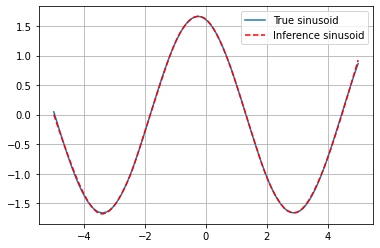

In [13]:
x_in = torch.Tensor(x).view(-1,1).to(device)
f_pred = model(x_in) #예측값
plt.plot(x,f_x,label='True sinusoid')
plt.plot(x,f_pred.cpu().detach().numpy(),'r--',label='Inference sinusoid')
plt.grid()
plt.legend()

- 만약 새로운 사인파를 만나게 된다면?
 - 거기에 5개의 포인트 (x,y)만 있다면???????

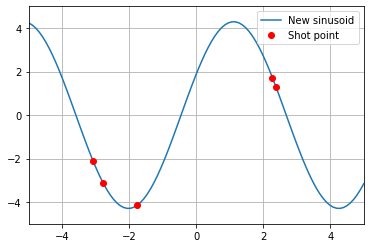

In [14]:
f_new = gen_sinusoid(x) #새로운 임의의 함수
idx = np.random.choice(np.arange(len(x)),5) # 5포인트 임의 추출
x_shot = x[idx]
f_new_shot = f_new[idx]
plt.plot(x,f_new,'-',label='New sinusoid')
plt.plot(x_shot,f_new_shot,'ro',label='Shot point')
plt.grid()
plt.axis([-5,5,-5,5])
plt.legend()

5번의 학습횟수로 기존지식을 통해 얼마나 잘 맞추는지 평가해봅시다

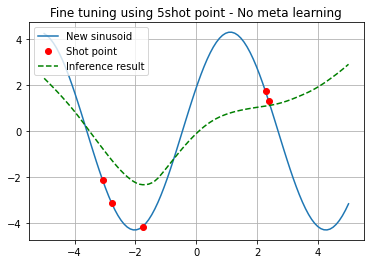

In [15]:
transfer_epoch = 5
for e in range(transfer_epoch):
  opt.zero_grad()
  X = torch.Tensor(x_shot).view(-1,1).to(device) # (x,y) --> 5쌍(K) 에 대한 정보로 5회(epoch) 학습
  Y = torch.Tensor(f_new_shot).view(-1,1).to(device)
  Y_pred = model(X)
  loss = torch.mean((Y-Y_pred)**2)
  loss.backward()
  opt.step()

plt.plot(x,f_new,'-',label='New sinusoid')
plt.plot(x_shot,f_new_shot,'ro',label='Shot point')
plt.plot(x,model(torch.Tensor(x).view(-1,1).to(device)).detach().cpu().numpy(),'g--',label='Inference result')
plt.title('Fine tuning using 5shot point - No meta learning')
plt.grid()
plt.legend()

- Meta-learning with Higher library

Higher 라이브러리를 통해서 쉽게 Meta-learning을 구현해봅시다.

Higher 라이브러리 --> inner loop를 쉽게 해결할 수 있도록 구현된 라이브러리

In [16]:
num_meta_train = 1000 #메타학습횟수
num_inner_loop = 5 #새로운 sin을 만날때마다 5회씩 학습
task_batch = 32
num_shot = 5
inner_lr = 5e-03 #학습률
outer_lr = 5e-03 #학습률

In [19]:
meta_model = simple_sinusoid().to(device)
meta_opt = optim.Adam(meta_model.parameters(),lr=outer_lr)

for epoch in range(num_meta_train):
  meta_opt.zero_grad()
  inner_opt = optim.Adam(meta_model.parameters(),lr=inner_lr)

  batch_loss = []
  for task in range(task_batch):  #32개의 임의의 사인파 추출
    idx = np.random.choice(np.arange(len(x)),num_shot)
    f_x = gen_sinusoid(x)
    x_shot,y_shot = x[idx].reshape(-1,1),f_x[idx].reshape(-1,1)

    train_x = torch.Tensor(x_shot).to(device) #5개
    train_y = torch.Tensor(y_shot).to(device) #5개
    vaild_x = torch.Tensor(x.reshape(-1,1)).to(device) # 1000개
    vaild_y = torch.Tensor(f_x.reshape(-1,1)).to(device) # 1000개

    with higher.innerloop_ctx(meta_model,inner_opt,copy_initial_weights=False) as (fnet,diffopt):
      # inner training (5회 반복)
      for _ in range(num_inner_loop):
        y_infer = fnet(train_x)
        y = train_y
        inner_loss = torch.mean((y_infer-y)**2)
        diffopt.step(inner_loss)

      # outer training
      y_infer = fnet(vaild_x)
      y = vaild_y
      meta_loss = torch.mean((y_infer-y)**2)
      batch_loss.append(meta_loss.item())
      meta_loss.backward()
  meta_opt.step()  # outer loop == meta-learning

  if epoch % 100 == 0:
    print('Epoch: {:d}, Validation task loss: {:.4f}'.format(epoch,sum(batch_loss)/task_batch))

Epoch: 0, Validation task loss: 5.7970
Epoch: 100, Validation task loss: 1.5954
Epoch: 200, Validation task loss: 1.3331
Epoch: 300, Validation task loss: 1.9068
Epoch: 400, Validation task loss: 1.6063
Epoch: 500, Validation task loss: 1.1177
Epoch: 600, Validation task loss: 0.8969
Epoch: 700, Validation task loss: 1.3438
Epoch: 800, Validation task loss: 0.6980
Epoch: 900, Validation task loss: 1.0565


In [20]:
torch.save(meta_model,'/meta_model.pth')

- 똑같이 검증을 해봅시다
 1. 사인파에서 임의의 5개 포인트(x,y)를 추출한다
 2. Meta-learning이 끝났으니 Task learning(inner loop)를 이용하여 문제해결

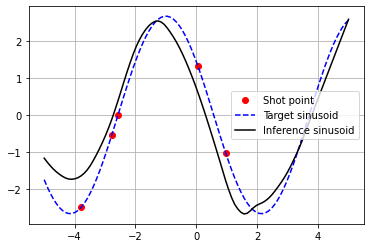

In [32]:
f_x = gen_sinusoid(x) # 임의의 다섯개의 사인파를 만들고
idx = np.random.choice(np.arange(len(x)),num_shot)
x_shot,y_shot = x[idx].reshape(-1,1),f_x[idx].reshape(-1,1) #5개를 추출한다

train_x = torch.Tensor(x_shot).to(device) #5개
train_y = torch.Tensor(y_shot).to(device) #5개
valid_x = torch.Tensor(x.reshape(-1,1)).to(device) # 1000개
valid_y = torch.Tensor(f_x.reshape(-1,1)).to(device) # 1000개


#여기부터

with higher.innerloop_ctx(meta_model,inner_opt,copy_initial_weights=False) as (fnet,diffopt):
  #inner training
  for _ in range(num_inner_loop):
    y_infer = fnet(train_x)
    y = train_y
    inner_loss = torch.mean((y_infer-y)**2)
    diffopt.step(inner_loss)


#여기까지 task learning


  y_infer = fnet(valid_x)

y = valid_y.detach().cpu().numpy()


plt.plot(x_shot,y_shot,'ro',label='Shot point')
plt.plot(x,f_x,'b--',label='Target sinusoid')
# Vaildation (x,y)
val_x = vaild_x.detach().cpu().numpy()
val_y = y_infer.detach().cpu().numpy()
plt.plot(val_x,val_y,'k-',label='Inference sinusoid')
plt.grid()
plt.legend()